In [1]:
from sys import path
path.append('..')
path.append('../../src/')

import os
import cv2
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import mlflow
import mlflow.keras
import random as rn
import tensorflow as tf
from os.path import basename, join

from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout, BatchNormalization, Activation
from keras.layers import Conv2D, Conv2DTranspose, MaxPool2D, UpSampling2D, GlobalAvgPool2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.vis_utils import plot_model

from skmultilearn.model_selection import iterative_train_test_split

from tensorflow.contrib.tensorboard.plugins import projector

from global_config import RANDOM_SEED, IMAGE_SIZE, FILE_DUMP_IMAGES, FILE_DUMP_MRKS
from local_config import FOLDER_MODELS, FILE_AUTOENCODER_SAMPLES
from custom_metrics import precision, recall, f1, specificity, fbeta
from custom_metrics import negative_predictive_value as npv 
from custom_metrics import matthews_correlation_coefficient as mcc
from utils import plot, load

%matplotlib inline

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\util\nest.py:823: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  _pywrap_tensorflow.RegisterType("Mapping", _collections.Mapping)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\data_structures.py:312: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ListWrapper(List, collections.MutableSequence,
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\util.py:448: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ObjectIdentitySet(collections.MutableSet):
Using Te

In [2]:
PATH_TO_ROOT = '../../'

FOLDER_LOGS = join(PATH_TO_ROOT, 'logs')
FOLDER_MODELS = join(PATH_TO_ROOT, FOLDER_MODELS)
FILE_DUMP_MRKS = join(PATH_TO_ROOT, FILE_DUMP_MRKS)
FILE_DUMP_IMAGES = join(PATH_TO_ROOT, FILE_DUMP_IMAGES)
FILE_AUTOENCODER_SAMPLES = join(PATH_TO_ROOT, FILE_AUTOENCODER_SAMPLES)

print(FOLDER_LOGS)
print(FOLDER_MODELS)
print(FILE_DUMP_MRKS)
print(FILE_DUMP_IMAGES)
print(FILE_AUTOENCODER_SAMPLES)

../../logs
../../models/unsupervised_supervised/
../../data/cropped_faces/cropped_faces_mrks.pkl
../../data/cropped_faces/cropped_faces_images.pkl
../../data/unsupervised_supervised_samples.pkl


In [3]:
TEST_SIZE = 0.1
MLFLOW_EXPERIMENT_NAME = 'Unsupervised + Supervised'

In [4]:
def timestamp_model_name(prefix='model_', suffix='', format='%Y_%m_%d-%H_%M_%S', ext='.h5'):
    from datetime import datetime
    timestamp = datetime.now().strftime(format)
    return f'{prefix}{timestamp}{suffix}{ext}'


def set_random_seeds():
    os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
    rn.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    tf.set_random_seed(RANDOM_SEED)

# Data Loading 

In [5]:
x, _ = pkl.load(open(FILE_DUMP_IMAGES, 'rb'))
mrks, _ = pkl.load(open(FILE_DUMP_MRKS, 'rb'))
y = np.array([mrk_file.photo_reqs.values() for mrk_file in mrks])

print(x.shape, x.dtype)
print(y.shape, y.dtype)
print(len(mrks))

(5731, 160, 160, 3) float32
(5731, 23) int32
5731


In [6]:
np.random.seed(RANDOM_SEED)
x_train_idx, y_train, x_val_idx, y_val = iterative_train_test_split(np.arange(x.shape[0]).reshape(-1, 1), y, test_size=TEST_SIZE)
x_train_idx = x_train_idx.ravel()
x_val_idx = x_val_idx.ravel()

x_train = x[x_train_idx]
x_val = x[x_val_idx]

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(5151, 160, 160, 3) (5151, 23)
(580, 160, 160, 3) (580, 23)


In [7]:
train_mrks = mrks[x_train_idx]
val_mrks = mrks[x_val_idx]

# pkl.dump((x_train, x_val, train_mrks, val_mrks), open(FILE_AUTOENCODER_SAMPLES, 'wb'), -1)

# Model Training 

In [8]:
x_train, x_val, _, _ = pkl.load(open(FILE_AUTOENCODER_SAMPLES, 'rb'))
x_train /= 255.0
x_val /= 255.0

print(x_train.shape, x_train.dtype, x_train.min(), x_train.max())
print(x_val.shape, x_val.dtype, x_val.min(), x_val.max())

(5151, 160, 160, 3) float32 0.0 1.0
(580, 160, 160, 3) float32 0.0 1.0


In [9]:
def conv_bn(idx, prev_input, filters, activation='relu', name=None):
    conv_name = 'conv_' + str(idx)
    bn_name = 'bn_' + str(idx)
    act_name = f'{activation}_' + str(idx) if name is None else name
    
    conv = Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=None, name=conv_name)(prev_input)
    conv = BatchNormalization(axis=-1, name=bn_name)(conv)
    conv = Activation(activation, name=act_name)(conv)
    return conv


def conv_bn_maxpool(idx, prev_input, filters):
    pool_name = 'pool_' + str(idx)
    
    conv = conv_bn(idx, prev_input, filters)
    pool = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid', name=pool_name)(conv)
    return pool


def deconv_bn(idx, prev_input, filters, activation='relu'):
    bn_name = str(idx) + '_bn' 
    act_name = str(idx) + '_relu' 
    conv_name = str(idx) + '_conv' 
    
    deconv = Conv2DTranspose(filters, kernel_size=(3, 3), strides=(2, 2), padding='same', activation=None, name=conv_name)(prev_input)
    deconv = BatchNormalization(axis=-1, name=bn_name)(deconv)
    deconv = Activation(activation, name=act_name)(deconv)
    return deconv


def dense_layer(idx, prev_input, units, dropout=True, rate=0.5, activation='relu'):
    dense_name = f"dense_{idx}"
    drop_name = f"dropout_{idx}"
    
    if dropout:
        prev_input = Dropout(rate)(prev_input)
    out = Dense(units, activation=activation)(prev_input)
    return out

In [10]:
mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
mlflow.log_param("test_size", TEST_SIZE)
mlflow.log_param("seed", RANDOM_SEED)
mlflow.keras.autolog()

set_random_seeds()
N_REQS = y_train.shape[1]

inputs = Input(shape=x_train.shape[1:], name='input')
pool_1 = conv_bn_maxpool(1, inputs, 32)
pool_2 = conv_bn_maxpool(2, pool_1, 64)
pool_3 = conv_bn_maxpool(3, pool_2, 128)
pool_4 = conv_bn_maxpool(4, pool_3, 256)
encode = conv_bn(5, pool_4, 256, activation='tanh', name='encoded')

dec_4 = deconv_bn(4, encode, 256)
dec_3 = deconv_bn(3, dec_4, 128)
dec_2 = deconv_bn(2, dec_3, 64)
dec_1 = deconv_bn(1, dec_2, 32)
decoded = Conv2D(filters=3, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='sigmoid', name='decoded')(dec_1)

avg_pool = GlobalAvgPool2D()(encode)
dense_1 = dense_layer(1, avg_pool, 64)
dense_2 = dense_layer(2, dense_1, 32)
classif = Dense(units=N_REQS, activation='sigmoid', name='outputs')(dense_2)

model = Model(inputs=inputs, outputs=[decoded, classif])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 160, 160, 32) 896         input[0][0]                      
__________________________________________________________________________________________________
bn_1 (BatchNormalization)       (None, 160, 160, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
relu_1 (Activation)             (None, 160, 160, 32) 0           bn_1[0][0]                       
____________________________________________________________________________________________

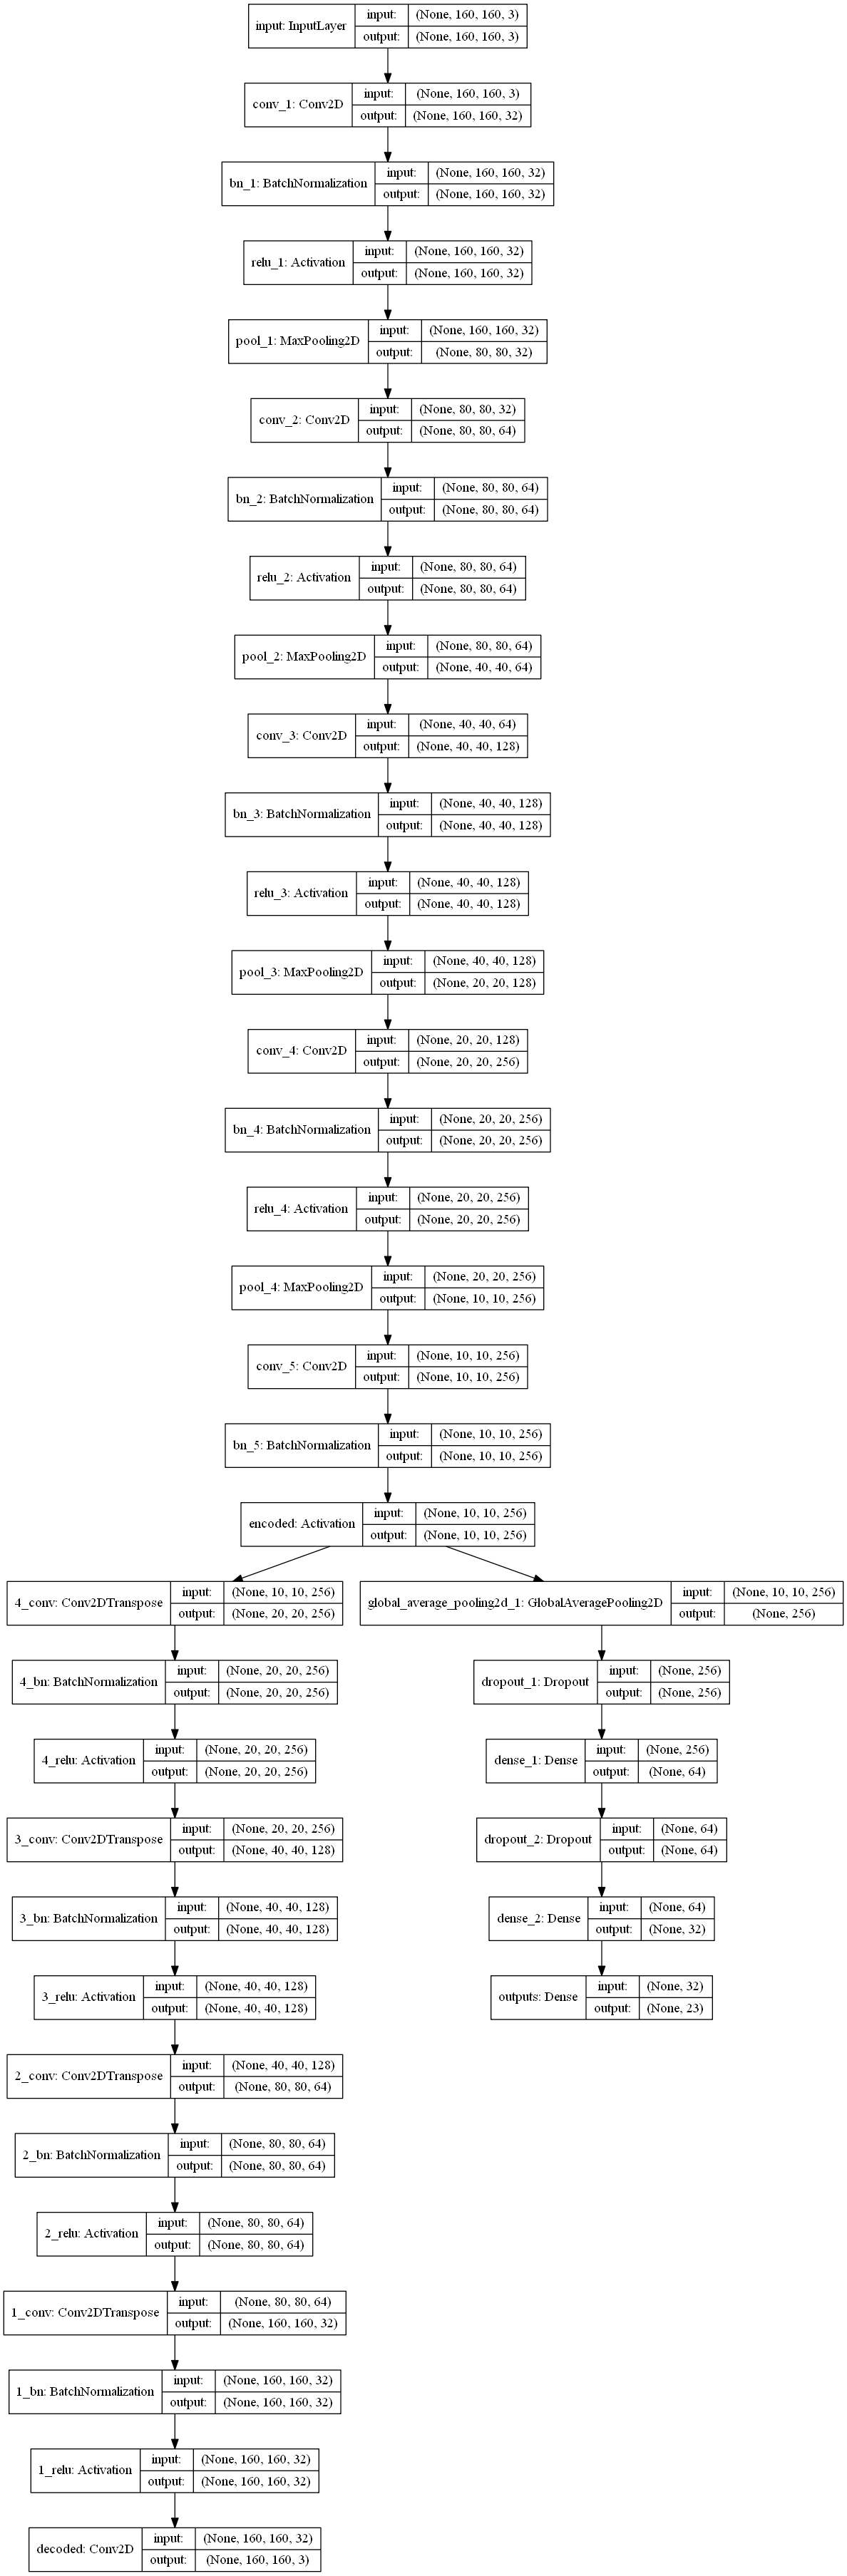

In [11]:
plot_model(model, show_shapes=True)

Instructions for updating:
Use tf.cast instead.


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 5151 samples, validate on 580 samples
Epoch 1/100
5151/5151 [==============================] - 59s 12ms/step - loss: 0.9571 - decoded_loss: 0.0213 - outputs_loss: 0.4679 - outputs_accuracy: 0.7792 - outputs_precision: 0.8357 - outputs_recall: 0.9005 - outputs_f1: 0.8652 - outputs_fbeta: 0.8828 - outputs_specificity: 0.2991 - outputs_negative_predictive_value: 0.4740 - outputs_matthews_correlation_coefficient: 0.2474 - val_loss: 1.1789 - val_decoded_loss: 0.0990 - val_outputs_loss: 0.5462 - val_outputs_accuracy: 0.7756 - val_outputs_precision: 0.7763 - val_outputs_recall: 0.9834 - val_outputs_f1: 0.8660 - val_outputs_fbeta: 0.9285 - val_outputs_specificity: 0.0059 - val_outputs_negative_predictive_value: 0.0482 - val_outputs_matthews_correlation_coefficient: -0.0354

Epoch 00001: val_outputs_fbeta improved from -inf to 0.92855, saving model to ../../models/unsupervised_supervised/multilearner_2020_07_11-14_23_10.h5
Epoch 2/100
5151/5151 [==============================] - 53s 10


Epoch 00010: val_outputs_fbeta did not improve from 0.94885
Epoch 11/100
5151/5151 [==============================] - 53s 10ms/step - loss: 0.5896 - decoded_loss: 0.0076 - outputs_loss: 0.2910 - outputs_accuracy: 0.8733 - outputs_precision: 0.8892 - outputs_recall: 0.9613 - outputs_f1: 0.9237 - outputs_fbeta: 0.9434 - outputs_specificity: 0.5232 - outputs_negative_predictive_value: 0.7710 - outputs_matthews_correlation_coefficient: 0.5651 - val_loss: 0.5758 - val_decoded_loss: 0.0156 - val_outputs_loss: 0.3054 - val_outputs_accuracy: 0.8768 - val_outputs_precision: 0.9056 - val_outputs_recall: 0.9219 - val_outputs_f1: 0.9116 - val_outputs_fbeta: 0.9167 - val_outputs_specificity: 0.6969 - val_outputs_negative_predictive_value: 0.7080 - val_outputs_matthews_correlation_coefficient: 0.6142

Epoch 00011: val_outputs_fbeta did not improve from 0.94885
Epoch 12/100
5151/5151 [==============================] - 53s 10ms/step - loss: 0.5721 - decoded_loss: 0.0071 - outputs_loss: 0.2825 - outpu

5151/5151 [==============================] - 53s 10ms/step - loss: 0.5035 - decoded_loss: 0.0063 - outputs_loss: 0.2486 - outputs_accuracy: 0.8920 - outputs_precision: 0.9049 - outputs_recall: 0.9663 - outputs_f1: 0.9345 - outputs_fbeta: 0.9512 - outputs_specificity: 0.5965 - outputs_negative_predictive_value: 0.8162 - outputs_matthews_correlation_coefficient: 0.6367 - val_loss: 0.4598 - val_decoded_loss: 0.0080 - val_outputs_loss: 0.2411 - val_outputs_accuracy: 0.9109 - val_outputs_precision: 0.8982 - val_outputs_recall: 0.9866 - val_outputs_f1: 0.9393 - val_outputs_fbeta: 0.9655 - val_outputs_specificity: 0.6317 - val_outputs_negative_predictive_value: 0.9301 - val_outputs_matthews_correlation_coefficient: 0.7145

Epoch 00021: val_outputs_fbeta improved from 0.95994 to 0.96550, saving model to ../../models/unsupervised_supervised/multilearner_2020_07_11-14_23_10.h5
Epoch 22/100
5151/5151 [==============================] - 53s 10ms/step - loss: 0.4980 - decoded_loss: 0.0061 - outputs_

5151/5151 [==============================] - 53s 10ms/step - loss: 0.4456 - decoded_loss: 0.0056 - outputs_loss: 0.2200 - outputs_accuracy: 0.9075 - outputs_precision: 0.9197 - outputs_recall: 0.9688 - outputs_f1: 0.9435 - outputs_fbeta: 0.9565 - outputs_specificity: 0.6646 - outputs_negative_predictive_value: 0.8417 - outputs_matthews_correlation_coefficient: 0.6941 - val_loss: 0.5719 - val_decoded_loss: 0.0081 - val_outputs_loss: 0.2944 - val_outputs_accuracy: 0.8931 - val_outputs_precision: 0.9022 - val_outputs_recall: 0.9594 - val_outputs_f1: 0.9289 - val_outputs_fbeta: 0.9449 - val_outputs_specificity: 0.6545 - val_outputs_negative_predictive_value: 0.8135 - val_outputs_matthews_correlation_coefficient: 0.6621

Epoch 00031: val_outputs_fbeta did not improve from 0.96550
Epoch 32/100
5151/5151 [==============================] - 53s 10ms/step - loss: 0.4432 - decoded_loss: 0.0057 - outputs_loss: 0.2188 - outputs_accuracy: 0.9087 - outputs_precision: 0.9207 - outputs_recall: 0.9692 -

5151/5151 [==============================] - 53s 10ms/step - loss: 0.3998 - decoded_loss: 0.0054 - outputs_loss: 0.1972 - outputs_accuracy: 0.9182 - outputs_precision: 0.9293 - outputs_recall: 0.9715 - outputs_f1: 0.9498 - outputs_fbeta: 0.9608 - outputs_specificity: 0.7069 - outputs_negative_predictive_value: 0.8610 - outputs_matthews_correlation_coefficient: 0.7320 - val_loss: 0.4002 - val_decoded_loss: 0.0069 - val_outputs_loss: 0.1995 - val_outputs_accuracy: 0.9298 - val_outputs_precision: 0.9486 - val_outputs_recall: 0.9594 - val_outputs_f1: 0.9537 - val_outputs_fbeta: 0.9570 - val_outputs_specificity: 0.8276 - val_outputs_negative_predictive_value: 0.8505 - val_outputs_matthews_correlation_coefficient: 0.7925

Epoch 00041: val_outputs_fbeta did not improve from 0.96550
Epoch 42/100
5151/5151 [==============================] - 53s 10ms/step - loss: 0.3965 - decoded_loss: 0.0055 - outputs_loss: 0.1955 - outputs_accuracy: 0.9191 - outputs_precision: 0.9307 - outputs_recall: 0.9711 -

5151/5151 [==============================] - 53s 10ms/step - loss: 0.3627 - decoded_loss: 0.0052 - outputs_loss: 0.1788 - outputs_accuracy: 0.9264 - outputs_precision: 0.9369 - outputs_recall: 0.9734 - outputs_f1: 0.9547 - outputs_fbeta: 0.9640 - outputs_specificity: 0.7394 - outputs_negative_predictive_value: 0.8740 - outputs_matthews_correlation_coefficient: 0.7600 - val_loss: 0.5329 - val_decoded_loss: 0.0067 - val_outputs_loss: 0.2849 - val_outputs_accuracy: 0.9158 - val_outputs_precision: 0.9070 - val_outputs_recall: 0.9790 - val_outputs_f1: 0.9407 - val_outputs_fbeta: 0.9618 - val_outputs_specificity: 0.6730 - val_outputs_negative_predictive_value: 0.9054 - val_outputs_matthews_correlation_coefficient: 0.7271

Epoch 00051: val_outputs_fbeta did not improve from 0.96550
Restoring model weights from the end of the best epoch
Epoch 00051: early stopping


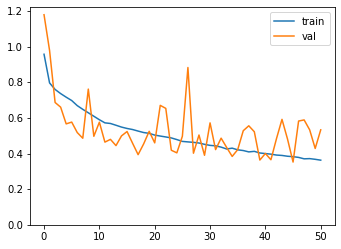

In [12]:
DECODED_LOSS_WEIGHT = 1.0
OUTPUTS_LOSS_WEIGHT = 2.0

mlflow.log_param("decoded loss weight", DECODED_LOSS_WEIGHT)
mlflow.log_param("outputs loss weight", OUTPUTS_LOSS_WEIGHT)

losses = {
    "decoded": "mean_squared_error",
    "outputs": "binary_crossentropy"
}

loss_weights = {
    "decoded": DECODED_LOSS_WEIGHT,
    "outputs": OUTPUTS_LOSS_WEIGHT
}

metrics = {
    "outputs": ["accuracy", precision, recall, f1, fbeta, specificity, npv, mcc]
}
METRIC_TO_MONITOR = "val_outputs_fbeta"

outputs_train = {
    "decoded": x_train,
    "outputs": y_train
}

outputs_valid = {
    "decoded": x_val,
    "outputs": y_val
}

model.compile(optimizer='adam', loss=losses, loss_weights=loss_weights, metrics=metrics)

FILE_MODEL = FOLDER_MODELS + timestamp_model_name(prefix="multilearner_")
list_callbacks = [
    ModelCheckpoint(FILE_MODEL, monitor=METRIC_TO_MONITOR, mode="max", verbose=1, save_best_only=True), 
    EarlyStopping(monitor=METRIC_TO_MONITOR, mode="max", patience=30, verbose=1, restore_best_weights=True)
]

hist = model.fit(
    x=x_train,
    y=outputs_train,
    batch_size=32,
    epochs=100,
    validation_data=(x_val, outputs_valid),
    callbacks=list_callbacks
)

plot.keras_hist(hist.history)

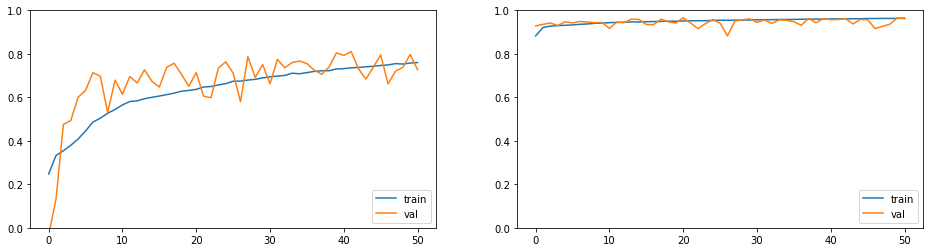

In [13]:
history = hist.history

plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot(history['outputs_matthews_correlation_coefficient'], label='train')
plt.plot(history['val_outputs_matthews_correlation_coefficient'], label='val')
plt.ylim(0, 1)
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history['outputs_fbeta'], label='train')
plt.plot(history['val_outputs_fbeta'], label='val')
plt.ylim(0, 1)
plt.legend(loc='lower right')

# Test Model

[1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1]
[1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1]


Text(0.5, 1.0, 'decoded image')

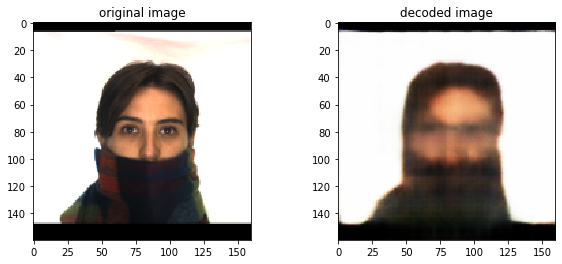

In [14]:
random_idx = np.random.choice(x_val.shape[0])
im = np.expand_dims(x_val[random_idx], axis=0)
y_true = y_val[random_idx] 

y_pred_decoded, y_pred_outputs = model.predict(im)
y_pred_outputs = np.where(y_pred_outputs > 0.5, 1, 0)

print(y_true, y_pred_outputs[0], sep='\n')

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(im.squeeze()[:, :, ::-1])
plt.title('original image')

plt.subplot(1, 2, 2)
plt.imshow(y_pred_decoded.squeeze()[:, :, ::-1])
plt.title('decoded image')

# Save Classification Model 

In [15]:
FILE_MODEL_CLF = FILE_MODEL.replace('multilearner', 'model')
print(FILE_MODEL_CLF)

model_clf = Model(inputs=model.inputs, outputs=model.get_layer('outputs').output, name="ICAOnet")
model_clf.summary()

model_clf.save(FILE_MODEL_CLF)

../../models/unsupervised_supervised/model_2020_07_11-14_23_10.h5
Model: "ICAOnet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 160, 160, 3)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 160, 160, 32)      896       
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 160, 160, 32)      128       
_________________________________________________________________
relu_1 (Activation)          (None, 160, 160, 32)      0         
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 80, 80, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 80, 80, 64)        18496     
___________________________________________________________

In [16]:
import cv2
from glob import glob

model_clf = load_model(FILE_MODEL_CLF)

list_files = [PATH_TO_ROOT + 'data/cropped_faces/images/AR_FDB_m-013-17.png']
random_file = np.random.choice(list_files)
print(random_file)

im = load.images_from_list_files([random_file], output_size=IMAGE_SIZE, interpolation=cv2.INTER_AREA)
im /= 255

y_pred_ori = model.predict(im)[1]
y_pred_clf = model_clf.predict(im)
assert(np.allclose(y_pred_ori, y_pred_clf))

for y_pred in y_pred_clf[0]:
    print(y_pred)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


../../data/cropped_faces/images/AR_FDB_m-013-17.png


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '



0.9998015
0.6773402
0.99996006
0.9838789
0.99999475
0.9965886
0.7868465
0.96243095
0.5586152
0.43084905
0.97141224
0.99736285
0.66130316
0.9976863
0.9975955
0.9994454
0.58903366
0.9999999
0.9532947
0.9999969
0.9990369
0.31318185
0.9999994


# Embeddings Visualization 

In [ ]:
FOLDER_LOGS = '../../logs/unsupervised_supervised/'

### Metadata 

In [ ]:
_, image_files = pkl.load(open(FILE_DUMP_IMAGES, 'rb'))
_, data, _, mrks = pkl.load(open(FILE_AUTOENCODER_SAMPLES, 'rb'))

image_files = [basename(filepath) for filepath in np.array(image_files)[x_val_idx]]
print(len(image_files))
print(data.shape)

In [ ]:
with open(f'{FOLDER_LOGS}/metadata.tsv', 'w') as metadata_file:
    for file in image_files:
        metadata_file.write(file+'\n')

mlflow.log_artifact(f'{FOLDER_LOGS}/metadata.tsv')

### Image Sprite

In [ ]:
def images_to_sprite(data):
    """Creates the sprite image along with any necessary padding
    Args:
      data: NxHxW[x3] tensor containing the images.
    Returns:
      data: Properly shaped HxWx3 image with any necessary padding.
    """
    if len(data.shape) == 3:
        data = np.tile(data[...,np.newaxis], (1,1,1,3))
    data = data.astype(np.float32)
    min_data = np.min(data.reshape((data.shape[0], -1)), axis=1)
    data = (data.transpose(1,2,3,0) - min_data).transpose(3,0,1,2)
    max_data = np.max(data.reshape((data.shape[0], -1)), axis=1)
    data = (data.transpose(1,2,3,0) / max_data).transpose(3,0,1,2)

    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, 0), (0, 0)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=0)
    
    # Tile the individual thumbnails into an image.
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    data = (data * 255).astype(np.uint8)
    return data### Embeddings 

In [ ]:
im_sprite = images_to_sprite(data)
print(im_sprite.shape)

cv2.imwrite(f'{FOLDER_LOGS}/sprites.png', im_sprite)
mlflow.log_artifact(f'{FOLDER_LOGS}/sprites.png')

### Embeddings 

In [ ]:
model = load_model(FILE_MODEL_CLF)

embeddings = GlobalAvgPool2D(name='embeddings')(model.get_layer(name='encoded').output)

model_emb = Model(inputs=model.inputs, outputs=embeddings)
model_emb.summary()

In [ ]:
emb_vectors = model_emb.predict(data)
print(emb_vectors.shape)

### Tensorboard 

In [ ]:
sess = tf.InteractiveSession()

tf_embeddings = tf.Variable(emb_vectors, name='embeddings')
summary_writer = tf.summary.FileWriter(f'{FOLDER_LOGS}')

config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = tf_embeddings.name
embedding.metadata_path = 'metadata.tsv'
embedding.sprite.image_path = 'sprites.png'
embedding.sprite.single_image_dim.extend(IMAGE_SIZE)

projector.visualize_embeddings(summary_writer, config)

saver = tf.train.Saver([tf_embeddings])
sess.run(tf_embeddings.initializer)
saver.save(sess, f'{FOLDER_LOGS}/embeddings.ckpt')

sess.close()

In [17]:
mlflow.end_run()